**Author:** Sandro Campos and the LINCC team \
**Last updated:** Aug 29, 2024

## Overview

In this notebook we'll learn how to:
- Load catalogs (lazily)
- Perform crossmatching with existing `LSDB` catalogs
- Save the results to disk

There is also an "Extra topics" section with details on crossmatching and margin caches.

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import astropy.units as u
from astropy.coordinates import SkyCoord

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hipscat.io.file_io import read_parquet_metadata

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

print(f'Version of lsdb is {lsdb.__version__}')

Version of lsdb is 0.2.10.dev40+g57dca96


We have numerous public catalogs available through [`data.lsdb.io`](https://data.lsdb.io).

In [2]:
catalogs_dir = "https://data.lsdb.io/unstable"

# Gaia
gaia_path = f"{catalogs_dir}/gaia_dr3/gaia"

# ZTF
ztf_object_path = f"{catalogs_dir}/ztf/ztf_dr14/"
ztf_source_path = f"{catalogs_dir}/ztf/ztf_zource/"
ztf_object_margin_path = f"{catalogs_dir}/ztf/ztf_dr14_10arcs"

In [3]:
%%time

# Define a 1 degree cone region of interest
cone_search = ConeSearch(ra=-60, dec=20.5, radius_arcsec=1*3600)

# Load lite version of Gaia DR3 (RA and DEC data only)
gaia_lite = lsdb.read_hipscat(gaia_path, columns=["ra", "dec"], search_filter=cone_search)

# Load all Gaia data for the cone
gaia = lsdb.read_hipscat(gaia_path, search_filter=cone_search)

CPU times: user 792 ms, sys: 191 ms, total: 984 ms
Wall time: 1.07 s


## Reading Parquet Metadata

HiPSCat uses the Parquet file format to store catalogs. Parquet is a binary columnar data format, which means that information is efficiently encoded and compressed in binary format on disk, and is stored column wise in a way which allows efficiently loading only a subset of the columns. With each column, Parquet stores the column's metadata, including the column's name and data type.

Parquet also supports large datasets being partitioned into multiple files that are easier to work with individually. With a partitioned dataset, like HiPSCat uses, there are metadata files at the root folder containing the partitioned files that store the combined and common metadata of each of the individual partition files metadata. Here, we can read this `_common_metadata` which includes the schema of the dataset, consisting of the column metadata for all the columns in the dataset.

In [4]:
list(read_parquet_metadata(os.path.join(gaia_path, "_common_metadata")).schema)[:2]

[<ParquetColumnSchema>
   name: _hipscat_index
   path: _hipscat_index
   max_definition_level: 1
   max_repetition_level: 0
   physical_type: INT64
   logical_type: Int(bitWidth=64, isSigned=false)
   converted_type (legacy): UINT_64,
 <ParquetColumnSchema>
   name: solution_id
   path: solution_id
   max_definition_level: 1
   max_repetition_level: 0
   physical_type: INT64
   logical_type: None
   converted_type (legacy): NONE]

## Lazy Operations

When working with large datasets, there is too much data to be loaded into memory at once. To get around this, LSDB uses the HiPSCat format which partitions a catalog into HEALPix cells and works on one partition at a time. This also allows the computation to be parallelized to work on multiple partitions at once. In order to efficiently carry out pipelines of operations though, it's better to batch operations so that multiple operations can be done back to back on the same partition instead of having to load and save each partition from storage after every operation.

For this reason, operations in LSDB are performed 'lazily'. This means when a catalog is read using `read_hipscat`, the actual catalog data isn't being read from storage. Instead, it only loads the metadata such as the column schema and the HEALPix structure of the partitions. When an operation like `cone_search` is called on a catalog, the data is not actually loaded and operated on when the line of code is executed. Instead, the catalog keeps track of the operations that it needs to perform so the entire pipeline can be efficiently run later. This also allows us to optimize the pipeline by only loading the partitions that are necessary. For example when performing a cone search like we do here, we only need the partitions that have data within the cone.

![lazy loading diagram](https://raw.githubusercontent.com/astronomy-commons/lsdb/main/docs/_static/lazy_diagram.svg)

So when we look at a catalog that has been lazy loaded we see the DataFrame without the data, just the columns and the number of partitions (including the HiPSCat index of each partition encoding which HEALPix cell the partition is in). 

In [5]:
gaia_lite

Dask NestedFrame Structure:
                                   ra              dec
npartitions=4                                         
3645663898356416512   double[pyarrow]  double[pyarrow]
3646789798263259136               ...              ...
3652700772774182912               ...              ...
3653545197704314880               ...              ...
18446744073709551615              ...              ...
Dask Name: search_points, 5 expressions
Expr=MapPartitions(search_points)

To load the data and perform the operations, call `compute()` which will load the necessary data and perform all the operations that have been called, and return a Pandas DataFrame with the results.

In [6]:
gaia_lite_computed = gaia_lite.compute()

In [7]:
gaia_lite_computed

ra        dec
_hipscat_index                            
3646064119989141504     300.323   19.54927
3646067005166977024  300.354463  19.558069
3646067005322166272  300.353417  19.558007
3646067036225798144  300.336424  19.551617
3646067036804612096  300.336033  19.552258
...                         ...        ...
3653836065044692992  300.117206  21.493197
3653836065845805056  300.119462  21.492589
3653836066403647488  300.118743  21.493434
3653836070195298304  300.124771   21.49295
3653836157197746176  300.114821  21.494043

[804414 rows x 2 columns]

## HiPSCat Partitioning

To make it easier and more efficient to perform operations in parallel, HiPSCat partitions contain roughly the same number of rows. This is done by using different HEALPix pixel sizes for different parts of the sky depending on the density of sources. This means catalogs with more rows will have smaller pixels for each partition, and so will have more partitions overall. We can see this below with the ZTF object and source catalogs, where the source catalog with many more data points has more partitions to keep the size of each partition consistent.

In [8]:
%%time
ztf_object = lsdb.read_hipscat(ztf_object_path, columns=["ra", "dec"]) # ZTF Object
ztf_source = lsdb.read_hipscat(ztf_source_path, columns=["ra", "dec"]) # ZTF Source

CPU times: user 3.72 s, sys: 465 ms, total: 4.18 s
Wall time: 4.19 s


In [9]:
ztf_object

Dask NestedFrame Structure:
                                   ra              dec
npartitions=2352                                      
0                     double[pyarrow]  double[pyarrow]
18014398509481984                 ...              ...
...                               ...              ...
13830554455654793216              ...              ...
18446744073709551615              ...              ...
Dask Name: nestedframe, 3 expressions
Expr=MapPartitions(NestedFrame)

In [10]:
ztf_source

Dask NestedFrame Structure:
                                   ra              dec
npartitions=41679                                     
0                     double[pyarrow]  double[pyarrow]
4503599627370496                  ...              ...
...                               ...              ...
13833932155375321088              ...              ...
18446744073709551615              ...              ...
Dask Name: nestedframe, 3 expressions
Expr=MapPartitions(NestedFrame)

We can see this difference in partition pixel sizes by plotting the HEALPix pixels of the partitions in the catalogs.

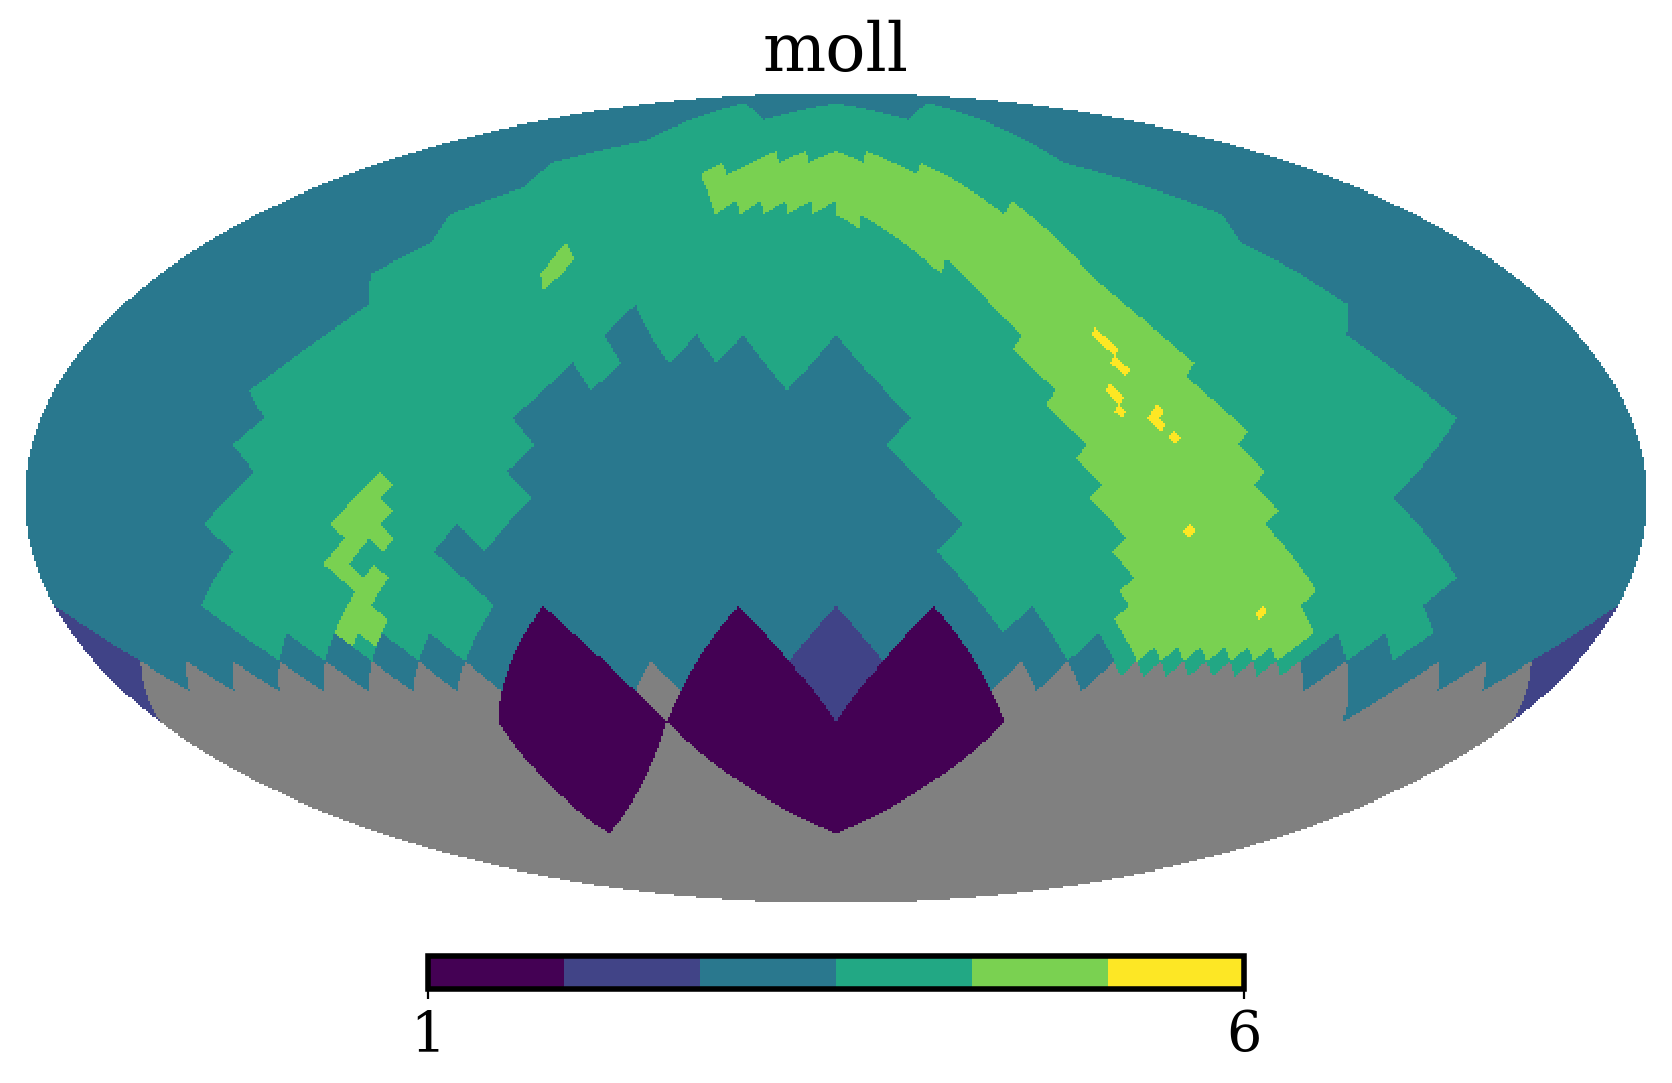

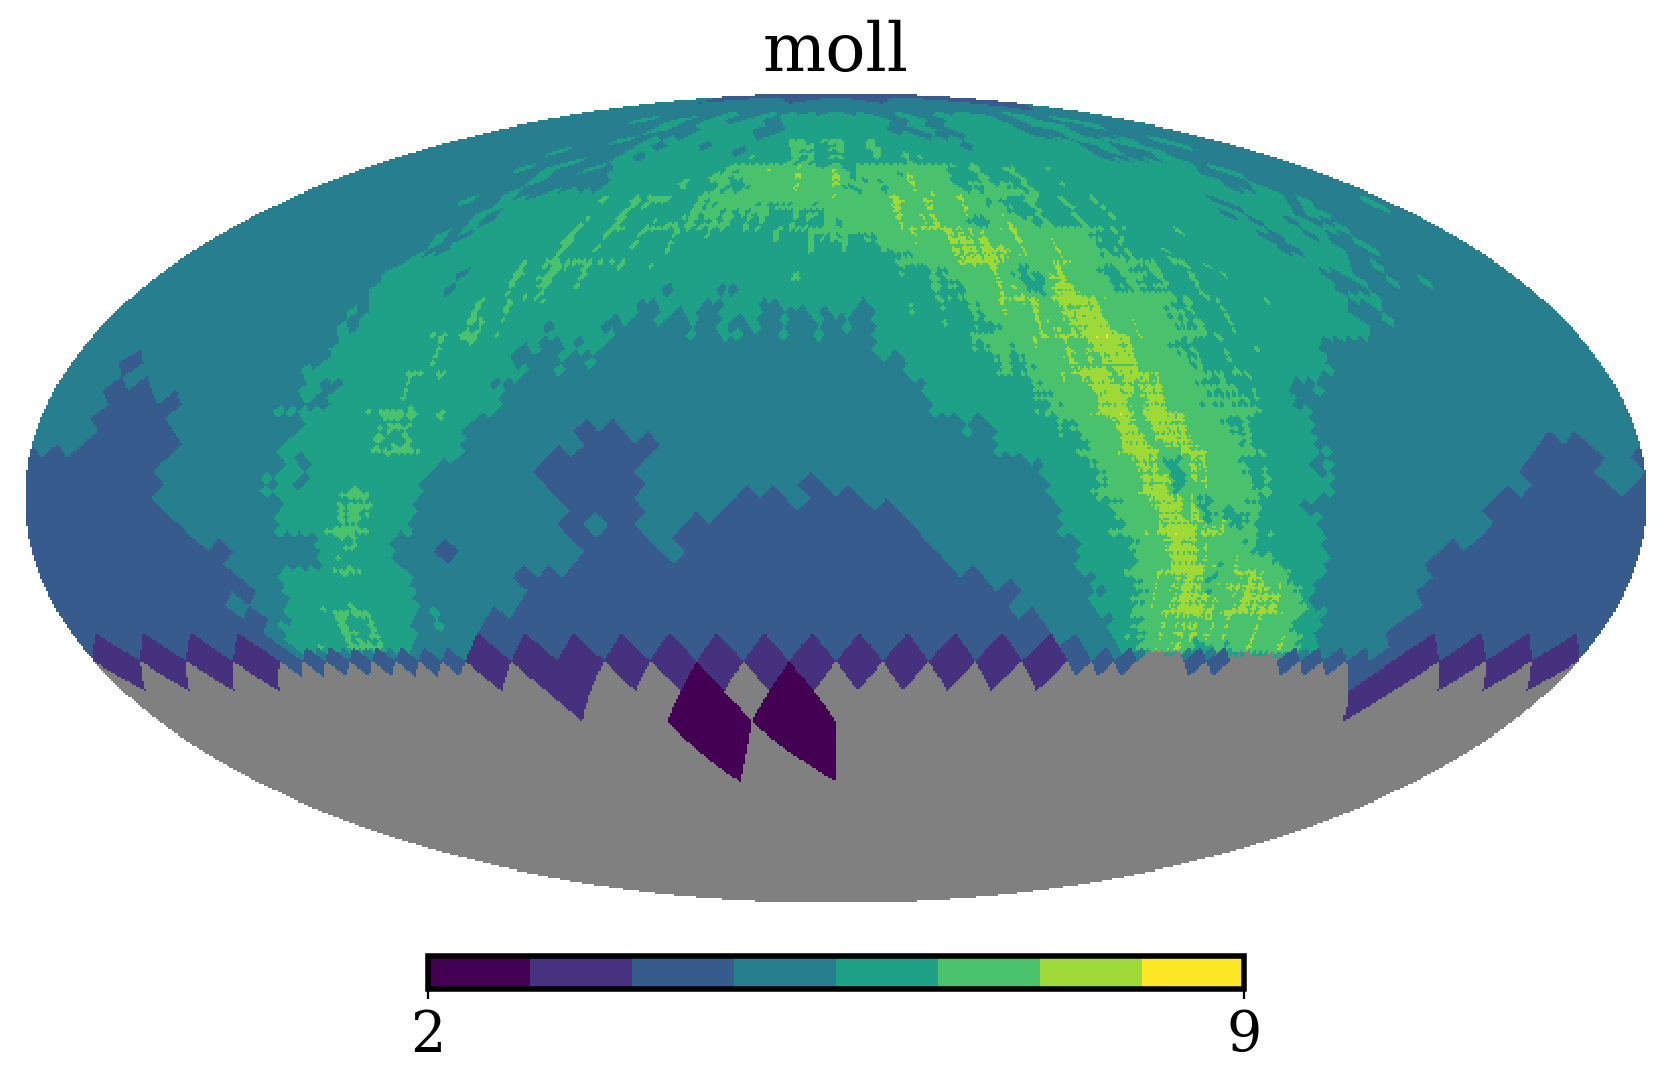

In [11]:
# Plot the Pixel Density Maps for Gaia and ZTF
# gaia.plot_pixels()
ztf_object.plot_pixels()
ztf_source.plot_pixels()

## Crossmatching

Let's crossmatch our Gaia region with ZTF.

In [12]:
%time
xmatch_object = gaia_lite.crossmatch(ztf_object)

CPU times: user 18 μs, sys: 8 μs, total: 26 μs
Wall time: 49.8 μs


/astro/users/smcampos/.conda/envs/busy-week/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


## The `head` method

For large operations we might want to see a small subset of the computed final data without doing the full computation. Like pandas, we can use the `head` operation to compute the first n rows of the final dataframe without computing the whole dataset.

In [13]:
xmatch_object.head(5)

ra_gaia   dec_gaia  ra_ztf_dr14  dec_ztf_dr14  \
_hipscat_index                                                          
3646064119989141504     300.323   19.54927   300.322998     19.549284   
3646067005166977024  300.354463  19.558069   300.354462     19.558081   
3646067005322166272  300.353417  19.558007   300.353401     19.558013   
3646067036225798144  300.336424  19.551617   300.336411     19.551633   
3646067039711264768  300.336573  19.552868   300.336571     19.552879   

                     _dist_arcsec  
_hipscat_index                     
3646064119989141504      0.050271  
3646067005166977024      0.043431  
3646067005322166272      0.058879  
3646067036225798144      0.072412  
3646067039711264768      0.039042

Here we load the ZTF object catalog again, this time with all the columns that we'll need to perform the analysis later. 

Note the previous warning about margin caches. Margins allow you to crossmatch objects which might be just across the border, in the neighboring pixels, which you might miss if you only search among the objects in a given pixel. We'll also be specifying the margin for ZTF.

In [14]:
%%time
# load ZTF with all columns and specify the margin cache!
ztf_object_full = lsdb.read_hipscat(ztf_object_path, margin_cache=ztf_object_margin_path)

CPU times: user 717 ms, sys: 82.7 ms, total: 799 ms
Wall time: 873 ms


In [15]:
%%time
# crossmatch ZTF + Gaia
_all_sky_object = gaia.crossmatch(ztf_object_full).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")

CPU times: user 4.98 s, sys: 143 ms, total: 5.12 s
Wall time: 5.12 s


In [16]:
%%time
total = _all_sky_object.compute()

CPU times: user 33.7 s, sys: 49.9 s, total: 1min 23s
Wall time: 16.9 s


In [17]:
# this is the dataframe with all the computed objects
total

solution_id_gaia              designation_gaia  \
_hipscat_index                                                           
3646067079259357184  1636148068921376768  Gaia DR3 1823033542087957248   
3646067849677504512  1636148068921376768  Gaia DR3 1823033920045097728   
3646068328969011200  1636148068921376768  Gaia DR3 1823034156246247424   
3646079368708489216  1636148068921376768  Gaia DR3 1823039658126194176   
3646079377201954816  1636148068921376768  Gaia DR3 1823039692480622976   
...                                  ...                           ...   
3653829094635732992  1636148068921376768  Gaia DR3 1826914543258245888   
3653829228861849600  1636148068921376768  Gaia DR3 1826914611977691264   
3653829247430033408  1636148068921376768  Gaia DR3 1826914611977688704   
3653829567539314688  1636148068921376768  Gaia DR3 1826914783776458624   
3653835666741002240  1636148068921376768  Gaia DR3 1826917807433482752   

                          source_id_gaia  random_index_gaia  ref_epoch_gaia  \
_hipscat_index                                                                
3646067079259357184  1823033542087957248          681413300          2016.0   
3646067849677504512  1823033920045097728          606871238          2016.0   
3646068328969011200  1823034156246247424          987360779          2016.0   
3646079368708489216  1823039658126194176         1633982299          2016.0   
3646079377201954816  1823039692480622976          367753372          2016.0   
...                                  ...                ...             ...   
3653829094635732992  1826914543258245888         1528507267          2016.0   
3653829228861849600  1826914611977691264         1690142768          2016.0   
3653829247430033408  1826914611977688704          996564350          2016.0   
3653829567539314688  1826914783776458624         1445282743          2016.0   
3653835666741002240  1826917807433482752          832277656          2016.0   

                        ra_gaia  ra_error_gaia   dec_gaia  dec_error_gaia  \
_hipscat_index                                                              
3646067079259357184  300.344658       0.028663  19.554414        0.027776   
3646067849677504512  300.426663       0.014488  19.587297        0.014479   
3646068328969011200  300.422159       0.042693  19.608572        0.041722   
3646079368708489216  300.549673       0.041812  19.653736        0.039993   
3646079377201954816    300.5315       0.037491  19.641191        0.035262   
...                         ...            ...        ...             ...   
3653829094635732992  300.190156        0.03939  21.451042        0.039384   
3653829228861849600  300.222469       0.036843  21.458198        0.039499   
3653829247430033408  300.229901       0.015495  21.465304        0.016096   
3653829567539314688  300.154678       0.031628  21.454938        0.034043   
3653835666741002240  300.133704       0.035317  21.486115        0.038298   

                     parallax_gaia  ...  nobs_g_ztf_dr14  nobs_r_ztf_dr14  \
_hipscat_index                      ...                                     
3646067079259357184       0.668537  ...              404             1009   
3646067849677504512        0.97283  ...              101              373   
3646068328969011200       0.350765  ...               94              362   
3646079368708489216       0.485155  ...              352              953   
3646079377201954816       0.380807  ...              396             1008   
...                            ...  ...              ...              ...   
3653829094635732992       0.311161  ...              398             1000   
3653829228861849600       0.474479  ...              376              953   
3653829247430033408       1.378988  ...              404             1004   
3653829567539314688       0.472456  ...              352              968   
3653835666741002240       0.499131  ...              352              948   

                     nobs_i_z

Let us now visualize the GAIA object that got matched and the all of the starting GAIA matches. The red circle shows the cone in which we conducted the cross-match. Note the patch where there are no cross-matches because of a gap in the ZTF coverage.

/astro/users/smcampos/.conda/envs/busy-week/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


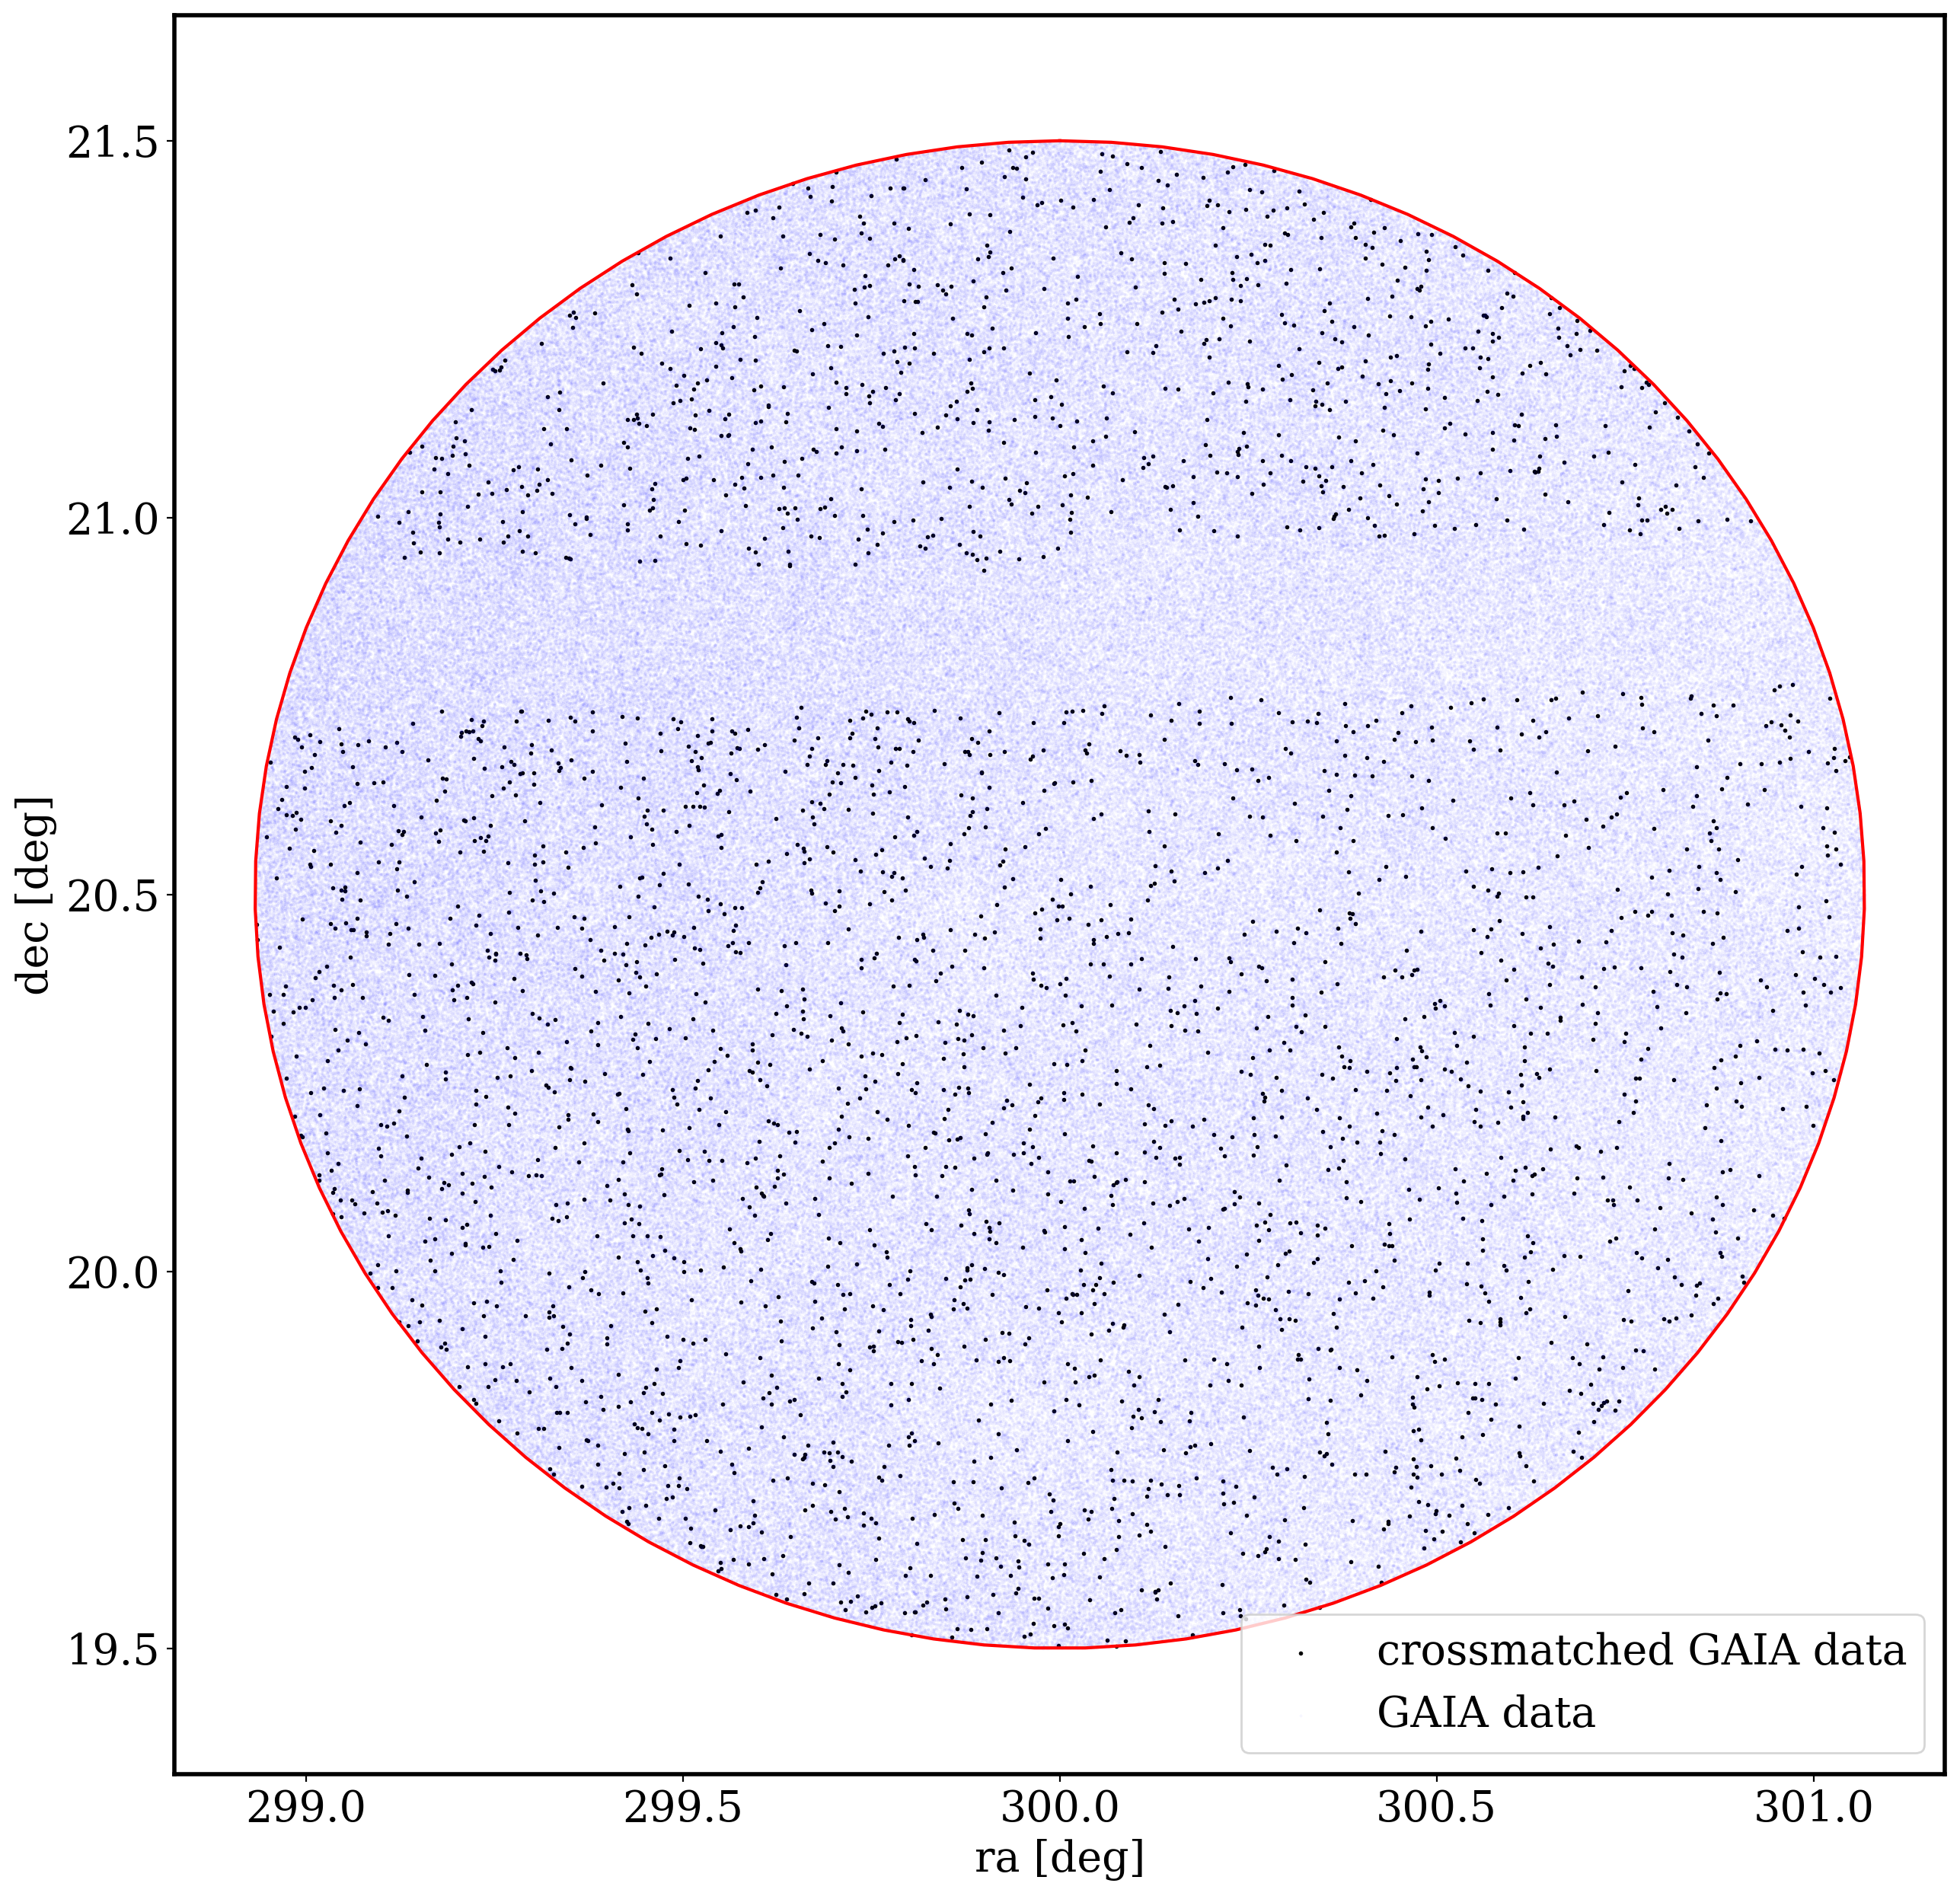

In [18]:
plt.figure(figsize=(15,15))
plt.scatter(total['ra_gaia'].values, total['dec_gaia'].values, color='black', s=1, label='crossmatched GAIA data')
plt.scatter(gaia_lite_computed['ra'], gaia_lite_computed['dec'], color='blue', s=0.1, alpha=0.05, label='GAIA data')

circle_center = SkyCoord(ra=300 * u.deg, dec=20.5 * u.deg)
circle_coord = circle_center.directional_offset_by(
    position_angle=np.linspace(0, 360, 100) * u.deg,
    separation=1 * u.deg
)
plt.plot(circle_coord.ra.deg, circle_coord.dec.deg, color='red')

plt.axis('equal')
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')
plt.legend()

## Export catalogs to disk

Once the analysis is complete we can export our results in the hipscat format. To do so you would uncomment the line below. You need to provide a base directory path for your catalog and you should also provide a catalog name that expresses the nature of your data. You can load the saved catalog back via LSDB, or you can load the parquet files that are saved to disk with any other parquet reader of your choice.

In [19]:
# export crossmatched data to disk
# _all_sky_object.to_hipscat(base_catalog_path="ztf_x_gaia", catalog_name="ztf_x_gaia")

## Extra topics

### Crossmatching

Catalogs have valuable metadata about their partitioning structure (e.g. the sky coverage and the order of the pixels at each point in the sky). LSDB takes advantage of this information for operations like joining/crossmatching to identify pairs of partitions that are spatially close to each other in the sky. Each core available to your distributed Dask client will process a pair of partitions at a time.

![Crossmatch diagram](https://raw.githubusercontent.com/lincc-frameworks/MWGaia-DN_Introductory_School/main/assets/crossmatch-diagram.jpg)

The built-in crossmatching algorithm is the **K-Nearest Neighbors**. By default, we look for single matches within 1 arcsecond of each object.

```python
gaia_lite.crossmatch(ztf_object, n_neighbors=1, radius_arcsec=1)
```

### Margin caches

Remember the **warning** about the missing margin cache?

```
RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
```

Margins are catalogs that specify what objects, for each pixel, are within a certain distance of their borders. They allows us to crossmatch objects which might be just across the border, in the neighboring pixels, which you might miss if you only search among the objects in a given pixel. 

In the image below we are trying to obtain the matches for the points in the "green" pixel. The closest match for the selected green object is in a different pixel. The closest green neighbor to this object is not even within the specified crossmatching radius (seen in dark green). This means that, without margin caches, this green object would simply not have a match, which is inaccurate!

![Margin cache diagram](https://lsdb.readthedocs.io/en/stable/_images/pixel-boundary-example.png)

Notice that your crossmatching distance, `radius_arcsec`, should not be larger than your margin cache radius. You can usually infer the margin cache radius from the catalog name, or look for it programatically.

In [20]:
ztf_object_full.margin.hc_structure.catalog_info.margin_threshold

10